In [11]:
import sys
sys.path.append("..")
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import utils.interp_generators as igs
import utils.adv_ex_utils as aus
import utils.utils as utils
from utils.models import LeNet, DDNet, SimpleCNN
from utils.data_loaders import DataLoader

# makes default tensor a CUDA tensor so GPU can be used
device = torch.device(2 if torch.cuda.is_available() else 'cpu')
if device != 'cpu':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.cuda.set_device(device)

In [12]:
dataset = 'MNIST'

if dataset == 'MNIST':
    net = LeNet()
    net2 = SimpleCNN()
elif dataset == 'CIFAR-10':
    net = DDNet()

# net_name = f'../trained_models/MNIST/training_round_{2}/ep{0}_wd{0}_jr{0}_{2}'
# net_name = f'../trained_models/CIFAR-10/tests/jr{0}_ir1{.00001}_ir2{.000001}_scale{.1}'
# net_name = f'../trained_models/CIFAR-10/training_round_1/ep0_wd0_jr0.01_1'
# net_name = f'../trained_models/CIFAR-10/training_round_1/ir1{.01}_ir2{0}_scale{.1}'
net_name = f'../trained_models/MNIST/interp_generators/lenet_pgd_eps1.5_niter40_epsiter.05_ord2_epochs85'
net2_name = f'../trained_models/MNIST/interp_generators/simplecnn_pgd_eps1.5_niter40_epsiter.05_ord2_epochs45'

net.load_state_dict(torch.load(net_name))
net2.load_state_dict(torch.load(net2_name))

# put model in evaluation mode. i.e. turn off dropout layers, etc.
net.eval()
net2.eval()

# get data
dl = DataLoader(dataset=dataset, tr_batch_size=1, te_batch_size=1, path='../data', augment=False)
test_loader = dl.test_loader
train_loader = dl.train_loader

### Check examples

In [13]:
def threshold(a):
    std = a.std()
    mean = a.mean()
    a = torch.where(a > mean + 1 * std, a, torch.tensor([0.]))
    return a

net(sample) = 4


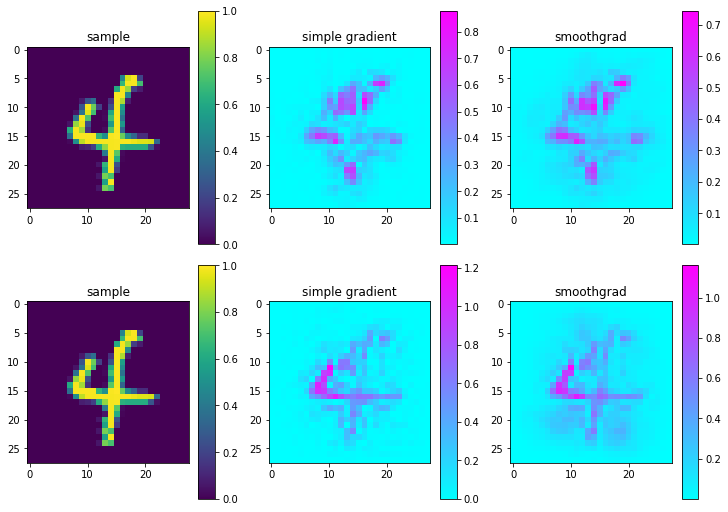

In [20]:
sample,label = next(iter(train_loader))
sample,label = sample.to(device),label.to(device)

# used = False needed if sample has not yet been converted to 
# a torch.Variable and made to require gradient
s1 = igs.simple_gradient(net, sample, label, used=False, normalize=False)
s2 = igs.smoothgrad(net, sample, label, j=50, scale=.15, used=False, normalize=False)

s21 = igs.simple_gradient(net2, sample, label, used=False, normalize=False)
s22 = igs.smoothgrad(net2, sample, label, j=50, scale=.15, used=False, normalize=False)


if dataset == 'CIFAR-10':
    sample = utils.rescale(sample)

sample = sample.squeeze()

if dataset == 'CIFAR-10':
    sample = sample.permute(1,2,0)

fig = plt.figure(figsize=(10,7), constrained_layout=True)
spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)

print(f'net(sample) = {label.item()}')

ax1 = fig.add_subplot(spec[0,0])
ax1.title.set_text('sample')
plt.imshow(sample.cpu().numpy())
plt.colorbar()

ax2 = fig.add_subplot(spec[0,1])
ax2.title.set_text('simple gradient')
plt.imshow(s1.squeeze().cpu().detach().numpy(), cmap='cool')
plt.colorbar()

ax3 = fig.add_subplot(spec[0,2])
ax3.title.set_text('smoothgrad')
plt.imshow(s2.squeeze().cpu().detach().numpy(), cmap='cool')
plt.colorbar()

ax1 = fig.add_subplot(spec[1,0])
ax1.title.set_text('sample')
plt.imshow(sample.cpu().numpy())
plt.colorbar()

ax2 = fig.add_subplot(spec[1,1])
ax2.title.set_text('simple gradient')
plt.imshow(s21.squeeze().cpu().detach().numpy(), cmap='cool')
plt.colorbar()

ax3 = fig.add_subplot(spec[1,2])
ax3.title.set_text('smoothgrad')
plt.imshow(s22.squeeze().cpu().detach().numpy(), cmap='cool')
plt.colorbar()

plt.show()

#### CIFAR-10 class labels
<font size="1"> 
    airplane : 0,
    automobile : 1,
    bird : 2,
    cat : 3,
    deer : 4,
    dog : 5,
    frog : 6,
    horse : 7,
    ship : 8,
    truck : 9
</font>

### Inspect effect of randomly perturbing a sample

max value: 1.0, min value: 0.0
max value: 1.0, min value: 0.0
net(sample1) = 3, net(sample2) = 3


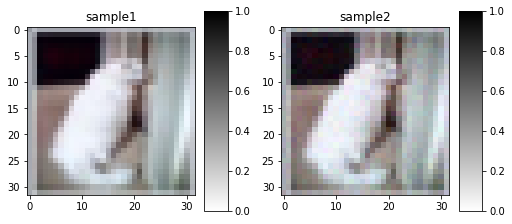

In [115]:
sample1,label1 = next(iter(train_loader))
sample1,label1 = sample1.to(device),label1.to(device)
# scale of .15 seems to be a good value for CIFAR-10
sample2 = aus.perturb_randomly(sample1, dataset=dataset, scale=.1)

if dataset == 'CIFAR-10':
    sample1,sample2 = utils.rescale(sample1), utils.rescale(sample2)

print(f'max value: {sample1.max().item()}, min value: {sample1.min().item()}')
print(f'max value: {sample2.max().item()}, min value: {sample2.min().item()}')
print(f'net(sample1) = {torch.argmax(net(sample1))}, net(sample2) = {torch.argmax(net(sample2))}')

sample1,sample2 = sample1.squeeze(),sample2.squeeze()

if dataset == 'CIFAR-10':
    sample1,sample2 = sample1.permute(1,2,0), sample2.permute(1,2,0)

fig = plt.figure(figsize=(7,3), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax1 = fig.add_subplot(spec[0,0])
ax1.title.set_text('sample1')
plt.imshow(sample1.cpu().numpy(), cmap='binary')
plt.colorbar()

ax2 = fig.add_subplot(spec[0,1])
ax2.title.set_text('sample2')
plt.imshow(sample2.cpu().numpy(), cmap='binary')
plt.colorbar()

plt.show()